# Experimentacion con tres clases de variantes del metodo SMOTE. 
#### *Autor: Juan Manuel Natello*
##### *juanmannat@gmail.com*

Resumen. El objetivo en este documento, es la realizacion de practicas de diferentes implementaciones de SMOTE. Mas precisamente se centra en tres tipos de filtrado sobre las instancias, una vez aplicado el sobremuestreo a las clases minoritarias. Estas metodos son: *SMOTE + Tomek*, *SMOTE + IPF* y *SMOTE + ENN*. 

Palabras Clave: smote, tomek link, ipf, enn, desequilibrio, conjuntos, filtrado, instancias.

##### Referencias: 
```
Ejemplo de uso de la libreria tomek links y smote: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
Ejemplo de uso de la libreria smote + IPF: 
Ejemplo de uso de la libreria smote + ENN: 
```


## 1. Introduccion

El problema de detección de fraude con tarjetas de crédito incluye el modelado de transacciones pasadas con tarjetas de crédito con el conocimiento de las que resultaron ser un fraude. Luego, este modelo se usa para identificar si una nueva transacción es fraudulenta o no. Nuestro objetivo aquí es detectar el 100% de las transacciones fraudulentas y minimizar las clasificaciones de fraude incorrectas.
Cuestiones a responder con el training aplicando sobremuestreo:
- No se estaria entrenando un modelo con ejemplos duplicados? 
- Si los ejemplos no son duplicados, entonces que garantia tengo que los generados pertenecen a la clase indicada?
- si no se producen ejemplos duplicados y los ejemplos generados estan bien clasificados.



   Unnamed: 0       ID GENDER CAR REALITY  NO_OF_CHILD    INCOME  \
0           0  5008806      M   Y       Y            0  112500.0   
1           1  5008808      F   N       Y            0  270000.0   
2           2  5008809      F   N       Y            0  270000.0   
3           3  5008810      F   N       Y            0  270000.0   
4           4  5008811      F   N       Y            0  270000.0   

            INCOME_TYPE                 EDUCATION_TYPE           FAMILY_TYPE  \
0               Working  Secondary / secondary special               Married   
1  Commercial associate  Secondary / secondary special  Single / not married   
2  Commercial associate  Secondary / secondary special  Single / not married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

          HOUSE_TYPE  FLAG_MOBIL  WORK_PHONE  PHONE  E_MAIL  FAMILY SIZE  \
0  House / apartment           1  

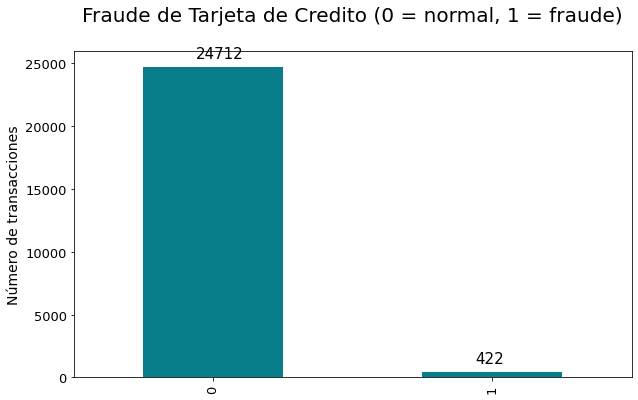

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

        
df = pd.read_csv('credit_dataset.csv')
print(df.head())

ax = df['TARGET'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Fraude de Tarjeta de Credito (0 = normal, 1 = fraude)', size=20, pad=30)
ax.set_ylabel('Número de transacciones', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)

In [3]:
# Reasignar a enteros
df['GENDER'] = [0 if x == 'M' else 1 for x in df['GENDER']]
df['CAR'] = [1 if x == 'Y' else 0 for x in df['CAR']]
df['REALITY'] = [1 if x == 'Y' else 0 for x in df['REALITY']]

# Crear variables ficticias
dummy_income_type = pd.get_dummies(df['INCOME_TYPE'], prefix='INC_TYPE', drop_first=True)
dummy_edu_type = pd.get_dummies(df['EDUCATION_TYPE'], prefix='EDU_TYPE', drop_first=True)
dummy_family_type = pd.get_dummies(df['FAMILY_TYPE'], prefix='FAM_TYPE', drop_first=True)
dummy_house_type = pd.get_dummies(df['HOUSE_TYPE'], prefix='HOUSE_TYPE', drop_first=True)

# Eliminar columnas innecesarias
to_drop = ['Unnamed: 0', 'ID', 'FLAG_MOBIL', 'INCOME_TYPE',
           'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']
df.drop(to_drop, axis=1, inplace=True)

# Fusionar en un solo Dataframe
merged = pd.concat([df, dummy_income_type, dummy_edu_type, dummy_family_type, dummy_house_type], axis=1)
merged.head()


,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,...,EDU_TYPE_Secondary / secondary special,FAM_TYPE_Married,FAM_TYPE_Separated,FAM_TYPE_Single / not married,FAM_TYPE_Widow,HOUSE_TYPE_House / apartment,HOUSE_TYPE_Municipal apartment,HOUSE_TYPE_Office apartment,HOUSE_TYPE_Rented apartment,HOUSE_TYPE_With parents
0,0,1,1,0,112500.0,0,0,0,2.0,29,...,1,1,0,0,0,1,0,0,0,0
1,1,0,1,0,270000.0,0,1,1,1.0,4,...,1,0,0,1,0,1,0,0,0,0
2,1,0,1,0,270000.0,0,1,1,1.0,26,...,1,0,0,1,0,1,0,0,0,0
3,1,0,1,0,270000.0,0,1,1,1.0,26,...,1,0,0,1,0,1,0,0,0,0
4,1,0,1,0,270000.0,0,1,1,1.0,38,...,1,0,0,1,0,1,0,0,0,0


### Normalizacion
Hay muchos métodos para la normalización de datos. Aca veremos la normalización min-max, la misma realiza una transformación lineal en los datos originales. Suponga que minA y maxA son los valores mínimo y máximo de un atributo, A. La normalización min-max mapea un valor, vi , de A a v 0 i en el rango [new minA,new maxA] calculando 
$$v_{i}^{'} = \frac{v_i - min_A}{max_A - min_A}(nuevoMax_A - nuevoMin_A) + nuevoMin_A (3.8)$$ 

La normalización min-max conserva las relaciones entre los valores de datos originales. Encontrará un error de "fuera de los límites" si un caso de entrada futuro para la normalización cae fuera del rango de datos original para A.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Escalar solo columnas que tengan valores mayores que 1
to_scale = [col for col in df.columns if df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Reemplazar las columnas originales con escalas
for col in scaled:
    merged[col] = scaled[col]
    
merged.head()

,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,...,EDU_TYPE_Secondary / secondary special,FAM_TYPE_Married,FAM_TYPE_Separated,FAM_TYPE_Single / not married,FAM_TYPE_Widow,HOUSE_TYPE_House / apartment,HOUSE_TYPE_Municipal apartment,HOUSE_TYPE_Office apartment,HOUSE_TYPE_Rented apartment,HOUSE_TYPE_With parents
0,0,1,1,0.0,0.055233,0,0,0,0.052632,0.483333,...,1,1,0,0,0,1,0,0,0,0
1,1,0,1,0.0,0.156977,0,1,1,0.000000,0.066667,...,1,0,0,1,0,1,0,0,0,0
2,1,0,1,0.0,0.156977,0,1,1,0.000000,0.433333,...,1,0,0,1,0,1,0,0,0,0
3,1,0,1,0.0,0.156977,0,1,1,0.000000,0.433333,...,1,0,0,1,0,1,0,0,0,0
4,1,0,1,0.0,0.156977,0,1,1,0.000000,0.633333,...,1,0,0,1,0,1,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split

X = merged.drop('TARGET', axis=1)
y = merged['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

print(f'''% Clase positiva en el entrenamiento = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Clase positiva en prueba  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

% Clase positiva en el entrenamiento = 1.69
% Clase positiva en prueba  = 1.65


Accuracy = 0.98
Exhaustividad = 0.09



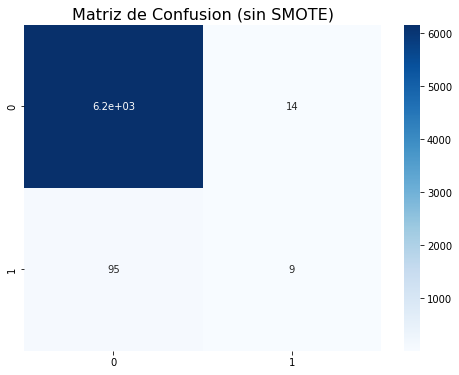

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

# Train
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# Evaluate
print(f'Accuracy = {accuracy_score(y_test, preds):.2f}\nExhaustividad = {recall_score(y_test, preds):.2f}\n')
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Matriz de Confusion (sin SMOTE)', size=16)
sns.heatmap(cm, annot=True, cmap='Blues');

#### Definicion de funciones:
Vamos a definir un par de funciones que utilizaremos para hacer los graficos y entrenamiento respectivamente posterior a la implementacion de la variantes y mejoras a SMOTE

In [8]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

def entrenar(X, y, variante):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f'Exactitud = {accuracy_score(y_test, preds):.2f}\nExhaustividad = {recall_score(y_test, preds):.2f}\n')
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    plt.title('Matriz de confusión (con '+ variante +')', size=16)
    sns.heatmap(cm, annot=True, cmap='Blues')

### Implementando SMOTE
Primero que nada, vamos a mostrar una implementacion con SMOTE, para luego ir viendo las mejorar que cada variante produce sobre metodo. Para esto nos valemos de la libreria desarrollada por György Kovács.

Documentacion de la libreria [**smote_variants**](https://smote-variants.readthedocs.io/_/downloads/en/stable/pdf/) de György Kovács

In [ ]:
import smote_variants as sv

2022-02-26 01:39:32,271:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


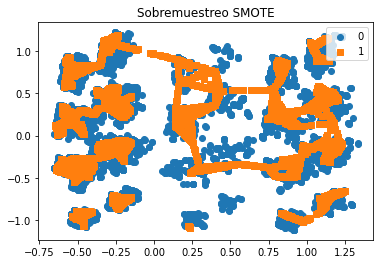

In [41]:
smote = sv.SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)

plot_2d_space(X_sm, y_sm, 'Sobremuestreo SMOTE')

Exactitud = 0.90
Exhaustividad = 0.91



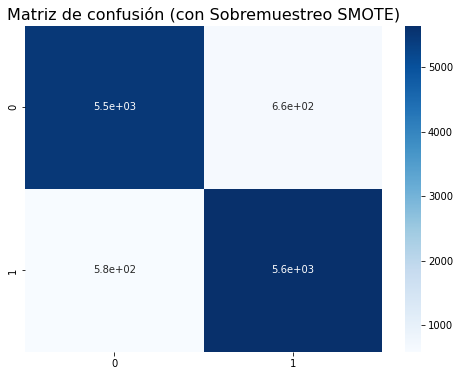

In [42]:
entrenar(X_sm, y_sm, 'Sobremuestreo SMOTE')

### 1. Primer variante, filtrado de instancias superpuestas y ruidosas: metodo de SMOTE + TomeK Links: 

Filtrado de instancias generadas con ruido: Las primeras extensiones de SMOTE motivadas por su conocido inconveniente de generar ejemplos superpuestos y ruidosos fue la adición de un paso de filtrado de ruido justo después de que finaliza el proceso de SMOTE. Dos técnicas típicas son SMOTE-TomekLinks y SMOTE+ENN (Batista et al., 2004). El filtrado de ejemplos artificiales es una operación frecuente que respalda el éxito de SMOTE en datos reales.

#### Enlaces de Tomek 
enlaces de Tomek [22] se pueden definir de la siguiente manera: dados dos ejemplos, $E_i$ y $E_j$ pertenecen a diferentes clases, y d($E_i$, $E_j$) es la distancia entre $E_i$ y $E_j$. Un par ($E_i$, $E_j$) se denomina enlace Tomek si no hay un ejemplo $E_l$, tal que d($E_i$, $E_l$) < d($E_i$, $E_j$) o d($E_j$, $E_l$) < d($E_i$, $E_j$). Si dos ejemplos forman un enlace Tomek, entonces uno de estos ejemplos es ruido o ambos ejemplos están en el límite. Los enlaces de Tomek se pueden utilizar como método de submuestreo o como método de limpieza de datos. Como método de submuestreo, solo se eliminan los ejemplos pertenecientes a la clase mayoritaria, y como método de limpieza de datos, se eliminan los ejemplos de ambas clases.
#### Enlaces Smote + Tomek 
Aunque el sobremuestreo de ejemplos de clases minoritarias puede equilibrar las distribuciones de clases, no se resuelven algunos otros problemas que normalmente se presentan en conjuntos de datos con distribuciones de clases asimétricas. Con frecuencia, los grupos de clases no están bien definidos, ya que algunos ejemplos de clases mayoritarias podrían estar invadiendo el espacio de clases minoritarias. Lo contrario también puede ser cierto, ya que la interpolación de ejemplos de clases minoritarias puede expandir los grupos de clases minoritarias, introduciendo ejemplos artificiales de clases minoritarias demasiado profundamente en el espacio de la clase mayoritaria. Inducir un clasificador en tal situación puede conducir a un sobreajuste. Para crear grupos de clases mejor definidos, proponemos aplicar enlaces de Tomek al conjunto de entrenamiento sobremuestreado como método de limpieza de datos. Por lo tanto, en lugar de eliminar solo los ejemplos de la clase mayoritaria que forman los enlaces de Tomek, se eliminan los ejemplos de ambas clases.


2022-02-26 01:38:07,460:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-02-26 01:38:07,535:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Python310\\\\lib\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-02-26 01:38:08,711:INFO:TomekLinkRemoval: Running noise removal via TomekLinkRemoval


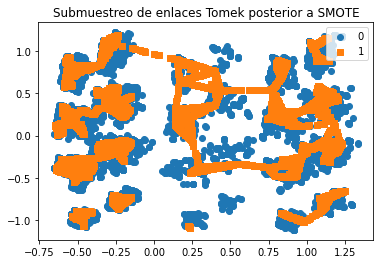

In [39]:
stl = sv.SMOTE_TomekLinks()
X_stl, y_stl  = stl.fit_resample(X, y)


plot_2d_space(X_stl, y_stl, 'Submuestreo de enlaces Tomek posterior a SMOTE')

Exactitud = 0.92
Exhaustividad = 0.93



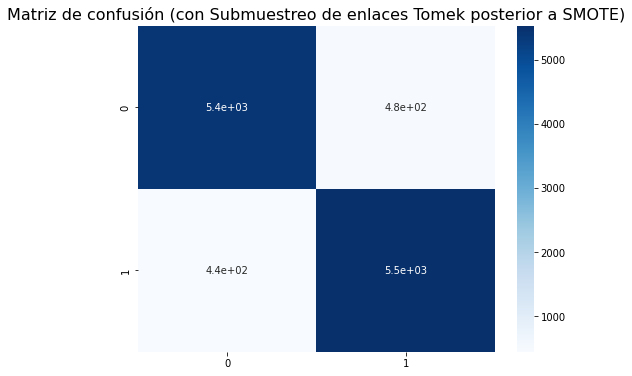

In [40]:
entrenar(X_stl, y_stl, 'Submuestreo de enlaces Tomek posterior a SMOTE')

Se puede observar una mejora tanto en la Precision como en la Exhaustividad del 93%. 

### 2. Tercera variante, filtrado mediante el submuestreo metodo de Smote + ENN
La motivación detrás de este método es similar a los enlaces Smote + Tomek. ENN tiende a eliminar más ejemplos que los enlaces de Tomek, por lo que se espera que proporcione una limpieza de datos más profunda. A diferencia de NCL (Regla de Limpieza de Vecindarios), que es un método de submuestreo, ENN se usa para eliminar ejemplos de ambas clases. Por lo tanto, cualquier ejemplo mal clasificado por sus tres vecinos más cercanos se elimina del conjunto de entrenamiento.

#### 2.1 Regla de limpieza de vecindarios 
La regla de limpieza de vecindarios (NCL) [15] utiliza  para eliminar ejemplos de clases mayoritarias. La regla de vecinos más cercanos editada (ENN) elimina cualquier ejemplo cuya etiqueta de clase difiera de la clase de al menos dos de sus tres vecinos más cercanos. NCL modifica el ENN para aumentar la limpieza de datos. Para un problema de dos clases, el algoritmo se puede describir de la siguiente manera: para cada ejemplo $E_i$ en el conjunto de entrenamiento, se encuentran sus tres vecinos más cercanos. Si $E_i$ pertenece a la clase mayoritaria y la clasificación dada por sus tres vecinos más cercanos contradice la clase original de $E_i$, entonces se elimina $E_i$. Si $E_i$ pertenece a la clase minoritaria y sus tres vecinos más cercanos clasifican erróneamente a $E_i$, entonces se eliminan los vecinos más cercanos que pertenecen a la clase mayoritaria.

2022-02-26 00:55:41,959:INFO:SMOTE_ENN: Running sampling via ('SMOTE_ENN', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-02-26 00:55:43,619:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Python310\\\\lib\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-02-26 00:55:44,139:INFO:EditedNearestNeighbors: Running noise removal via EditedNearestNeighbors


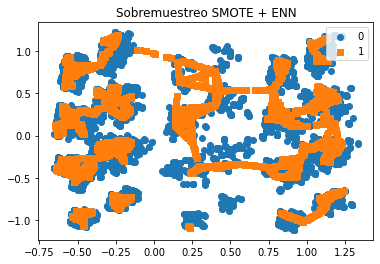

In [30]:
oversampler= sv.SMOTE_ENN()

# supposing that X and y contain some the feature and target data of some dataset
X_samp, y_samp= oversampler.sample(X, y)

plot_2d_space(X_samp, y_samp, 'Sobremuestreo SMOTE + ENN')

Exactitud = 0.96
Exhaustividad = 0.97



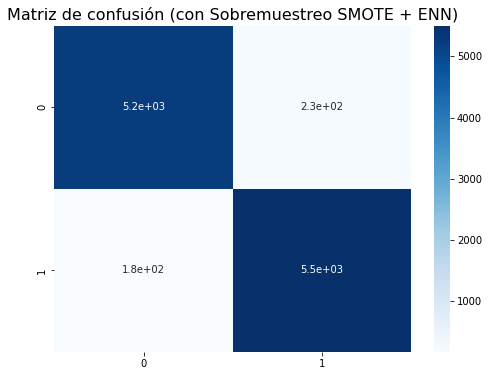

In [31]:
entrenar(X_samp, y_samp, 'Sobremuestreo SMOTE + ENN')

Como se puede observar una limpieza mas profunda de los vecinos cercanos, mejora significativamente tanto la precision como la Exhaustividad.

### 3. Segunda variante, filtrado basado filtro de ruido iterativo: metodo de SMOTE + IPF: 

Los conjuntos de datos de clasificación a menudo tienen una distribución de clases desigual entre sus ejemplos. Este problema se conoce como clasificación desequilibrada. La técnica de sobremuestreo de minorías sintéticas (SMOTE) es uno de los métodos de preprocesamiento de datos más conocidos para hacerle frente y equilibrar los diferentes números de ejemplos de cada clase. Sin embargo, como afirman trabajos recientes, el desequilibrio de clases no es un problema en sí mismo y la degradación del rendimiento también está asociada con otros factores relacionados con la distribución de los datos. Uno de ellos es la presencia de ruido y ejemplos límite, estos últimos ubicados en las áreas que rodean los límites de clase. Ciertas limitaciones intrínsecas de SMOTE pueden agravar el problema producido por este tipo de ejemplos.
Esta variante de SMOTE propone un filtro de ruido iterativo basado en conjuntos llamado Filtro de particion iterativa (IPF), que puede superar los problemas producidos por ejemplos ruidosos y limite en conjuntos de datos desequilibrados.

2022-02-26 01:45:54,741:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': DecisionTreeClassifier(random_state=2), 'random_state': None}")
2022-02-26 01:45:54,951:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Python310\\\\lib\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-02-26 01:46:05,257:INFO:SMOTE_IPF: Removing 43 elements
2022-02-26 01:46:11,720:INFO:SMOTE_IPF: Removing 0 elements
2022-02-26 01:46:16,263:INFO:SMOTE_IPF: Removing 0 elements


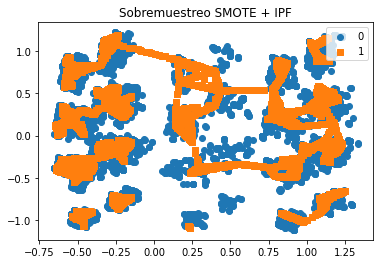

In [43]:
oversampler= sv.SMOTE_IPF()
X_samp, y_samp= oversampler.sample(X, y)
plot_2d_space(X_samp, y_samp, 'Sobremuestreo SMOTE + IPF')

Exactitud = 0.89
Exhaustividad = 0.90



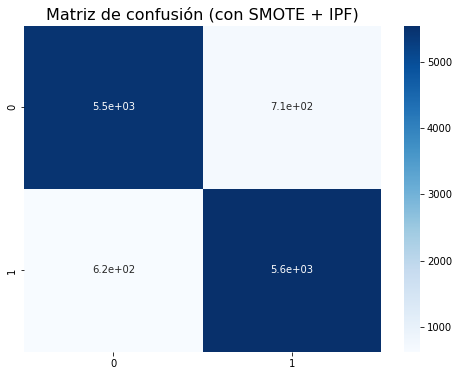

In [44]:
entrenar(X_samp, y_samp, 'SMOTE + IPF')

Sin embargo, no mejora a las anteriores implementaciones, teniendo la misma, inclusive un rendimiento mas bajo que la implementacion tradicional de SMOTE.